In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 
EPOCHS_BASE = 50 #or 100
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
folder = "./AirlineSentiment/"
label_names = ["negative","neutral","positive"]

### Load Data and preprocess

In [4]:
import re
FLAGS = re.MULTILINE | re.DOTALL
def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"
def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\S+", "<hashtag>")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", allcaps)
    return text.lower()

def read_texts(filename):
    f = open(filename)
    data = [line.strip() for line in f]
    f.close()
    return data

texts_train = [tokenize(text) for text in read_texts(folder+"texts_train.txt")]
#texts_test = [tokenize(text) for text in read_texts(folder+"texts_test.txt")]

Z_train = np.loadtxt(folder+"sent_train.txt", dtype='int')
#Z_test = np.loadtxt(folder+"sent_test.txt", dtype='int')

mask_gt = Z_train != -1
print("Num. train texts: %d" % len(texts_train))
#print("Num. test texts:  %d" % len(texts_test))

Num. train texts: 14680


In [13]:
folder_test = "./Sentiment/Semeval/"
texts_test = [tokenize(text) for text in read_texts(folder_test+"texts_data.txt")]

Z_test = np.loadtxt(folder_test+"sent_data.txt", dtype='int')

mask_data = Z_test <= 2
Z_test = Z_test[mask_data]
texts_test = list(np.asarray(texts_test)[mask_data])

print("Num. test texts:  %d" % len(texts_test))

Num. test texts:  3805


In [5]:
##mask Z_train to be test....
mask_gt = Z_train != -1

texts_test = list(np.asarray(texts_train)[mask_gt])
texts_train = list(np.asarray(texts_train)[~mask_gt])

Z_test = Z_train[mask_gt]
Z_train = Z_train[~mask_gt]

print("Num. train texts: %d" % len(texts_train))
print("Num. test texts:  %d" % len(texts_test))

Num. train texts: 14600
Num. test texts:  80


In [ ]:
## como tengo anotaciones en test podria utilizar para medir matrices de confusion "fuera" out of samplke

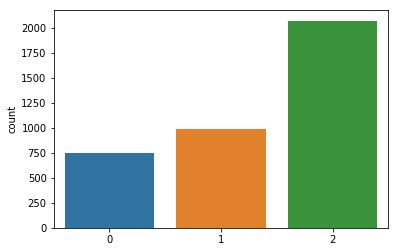

In [14]:
sns.countplot(Z_test)
plt.show()

In [17]:
from keras import preprocessing
MAX_NB_WORDS = 15000
tokenizer = preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_train+texts_test)
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)
MAX_NB_WORDS = len(tokenizer.word_index)
print('Found %s unique tokens.' % len(tokenizer.word_index))

Found 16224 unique tokens.


In [18]:
lens = list(map(len,sequences_train))
max_L = np.max(lens)
print("Real max: ",max_L)

X_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_L,dtype='int32', value=0,padding='pre')
X_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_L,dtype='int32', value=0,padding='pre')
print('Shape of train tensor:', X_train.shape)

Real max:  50
Shape of train tensor: (14680, 50)


In [20]:
EMBEDDING_DIM = 100
GLOVE_FILE = "../AUX_DATA/glove.twitter.27B/glove.twitter.27B.%dd.txt"%(EMBEDDING_DIM)
#GLOVE_FILE = "../GLOVE/glove.twitter.27B.%dd.txt"%(EMBEDDING_DIM)

embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[values[0]] = coefs
print('Preparing embedding matrix.')
sorted_x = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
vocab = {value[0]:tokenizer.word_index[value[0]] for i, value in enumerate(sorted_x) if i < MAX_NB_WORDS}
embedding_matrix = np.zeros((len(vocab)+1, EMBEDDING_DIM))
v=0
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # words not found in embedding index will be all-zeros.
        v+=1
del embeddings_index, sorted_x, tokenizer
gc.collect()
print("Words found on glove: ",v)

Preparing embedding matrix.
Words found on glove:  14161


### Load annotations / Generate

In [21]:
from code.representation import *
from code.utils import *

In [22]:
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt", delimiter=' ', dtype='int16')

#put mask
#y_obs = y_obs[~mask_gt]

T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]

T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Remove 0 annotators that do not annotate on this set 
Shape (data,annotators):  (14680, 503)
Classes:  3


In [ ]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

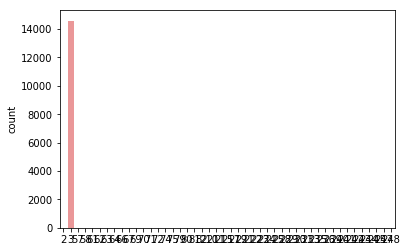

Minimum annotations in a example:  2
Maximum annotations in a example:  248
T data (expected value):  3.799931880108992
Graphics of T weights


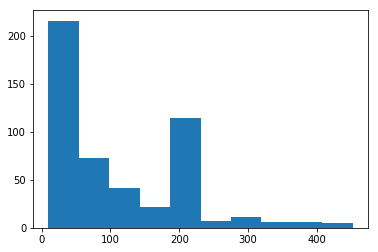

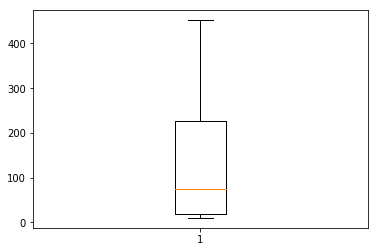

Minimum annotations by an annotator:  10
Maximum annotations by an annotator:  452
Mean annotations by an annotator:  110.90059642147118


In [20]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [23]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN_text,default_CNN_text, Clonable_Model

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [24]:
#Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_test_onehot = keras.utils.to_categorical(Z_test)

model_UB = default_RNN_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.summary()

#hist = model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
#print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
clone_UB = Clonable_Model(model_UB)
#Z_train_pred = model_UB.predict_classes(X_train)
#Z_test_pred = model_UB.predict_classes(X_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1622500   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 50, 128)           88320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 64)                37248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,748,263
Trainable params: 125,763
Non-trainable params: 1,622,500
____________________________________________________________

In [26]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_test_onehot = keras.utils.to_categorical(Z_test)

Representation for MV in 0.487544 sec
Representation for DS in 0.391745 sec
Estimation MV in 0.001091 sec


NameError: name 'Z_test' is not defined

In [22]:
from keras.models import Sequential,Model
from keras.layers import *
def default_CNN_text(input_dim,output_dim,embed_M=[]):
    model = Sequential() 
    if len(embed_M) != 0:
        T, R_t = embed_M.shape
        emd_layer = Embedding(T, R_t,trainable=False,weights=[embed_M],input_length=input_dim)
        model.add(emd_layer)
    else:
        model.add(InputLayer(input_shape=input_dim))
    model.add(Conv1D(128, 3, activation='relu')) #kernel 5?
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling1D())
    
    #model.add(Flatten())
    #model.add(Dense(32, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.25))
    
    model.add(Dense(output_dim, activation='softmax')) 
    return model
## muy parecida a la recurrente-.--

In [23]:
def default_RNN_text(input_dim,output_dim,embed_M=[]): 
    model = Sequential() 
    if len(embed_M) != 0:
        T, R_t = embed_M.shape
        emd_layer = Embedding(T, R_t,trainable=False,weights=[embed_M],input_length=input_dim)
        model.add(emd_layer)
    else:
        model.add(InputLayer(input_shape=input_dim))
    #model.add(Dropout(0.2))
    
    layer_gru1 = CuDNNGRU(128,return_sequences=True) #, dropout=0.2, recurrent_dropout=0.5)
    #model.add(Bidirectional(layer_gru1)) 
    model.add(layer_gru1)
    
    model.add(Dropout(0.25))
    
    layer_gru2 = CuDNNGRU(64,return_sequences=False) #, dropout=0.2, recurrent_dropout=0.5)
    #model.add(Bidirectional(layer_gru2)) #128 funciona con embd 100 (sin otra capa)
    model.add(layer_gru2) #128 funciona con embd 100 (sin otra capa)
    
    #model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    #model.add(Dense(32, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    
    model.add(Dense(output_dim, activation='softmax'))     
    return model

In [24]:
model_UB = default_RNN_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["accuracy"])
model_UB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1046200   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 50, 128)           88320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 64)                37248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,171,963
Trainable params: 125,763
Non-trainable params: 1,046,200
____________________________________________________________

In [25]:
hist=model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=2#,callbacks=[ourCallback]
                  ,validation_data=(X_test,Z_test_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))

NameError: name 'Z_train_onehot' is not defined

In [ ]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

### Infer Labels (without predictive model)

In [26]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

#confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 0.494737 sec
Representation for DS in 0.317282 sec
Estimation MV in 0.001232 sec


In [38]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)[mask_gt]==Z_train[mask_gt]))
#print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)[mask_gt]==Z_train[mask_gt]))

ACC MV on train: 1.0


In [39]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
hist=model_mvsoft.fit(X_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback],
                     validation_data=(X_test,Z_test_onehot))
                     # validation_split=0.2)
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_p  = model_mvsoft.predict(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_pred = model_mvsoft.predict_classes(X_test)

Train on 14680 samples, validate on 3805 samples
Epoch 1/50
14680/14680 [==============================] - 3s 227us/step - loss: 0.7234 - acc: 0.7274 - val_loss: 0.9951 - val_acc: 0.5477
Epoch 2/50
14680/14680 [==============================] - 2s 143us/step - loss: 0.5882 - acc: 0.7905 - val_loss: 1.2133 - val_acc: 0.4746
Epoch 3/50
14680/14680 [==============================] - 2s 144us/step - loss: 0.5608 - acc: 0.8037 - val_loss: 0.9732 - val_acc: 0.5742
Epoch 4/50
14680/14680 [==============================] - 2s 141us/step - loss: 0.5443 - acc: 0.8110 - val_loss: 1.1037 - val_acc: 0.5167
Trained model over soft-MV, Epochs to converge = 4


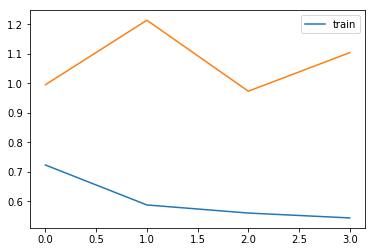

In [40]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [44]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(X_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_p = model_mvhard.predict(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_pred = model_mvhard.predict_classes(X_test)

Trained model over hard-MV, Epochs to converge = 4


In [46]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(X_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_p = model_ds.predict(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_pred = model_ds.predict_classes(X_test)

Trained model over D&S, Epochs to converge = 4


### Raykar Model (joint predict model)

In [23]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (4999, 203, 2)


In [ ]:
raykarMC = RaykarMC(max_L, y_obs_categorical.shape[-1], T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default rnn text", embed=embedding_matrix)

logL_hists,i_r = raykarMC.multiples_run(20,X_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

In [25]:
Z_train_p = raykarMC.get_predictions(X_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_p = raykarMC.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [19]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [20]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups

#get our representation 
r_obs = set_representation(y_obs,"repeat")
#confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 3 0]
 [1 1 1]
 [0 2 1]
 ...
 [0 3 0]
 [3 0 0]
 [1 2 0]]
shape: (14600, 3)


There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

In [ ]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=5,epochs=0,optimizer=OPT,dtype_op=DTYPE_OP) 

gMixture_Global.define_model("default rnn text", embed=embedding_matrix)

logL_hists,i_r = gMixture_Global.multiples_run(1,X_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

In [ ]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
uniform = True
for M_seted in range(1,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("default rnn text", embed=embedding_matrix)
        
        if uniform:
            #to uniform groups...
            gMixture_Global.define_priors("laplace")
            gMixture_Global.define_priors(uniform_groups) 
        
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Mean NormF"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

In [ ]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange
            )

In [ ]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

In [24]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [ ]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("default rnn text", embed=embedding_matrix)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

logL_hists,i_r = gMixture_Global.multiples_run(20,X_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)

In [26]:
Z_train_p = gMixture_Global.get_predictions(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [21]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (394, 394)


shape of annotator representation (T, R_t)= (394, 3)


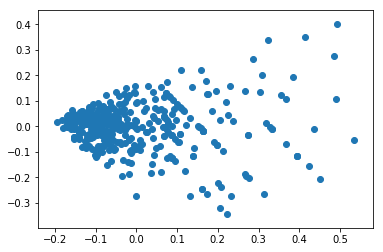

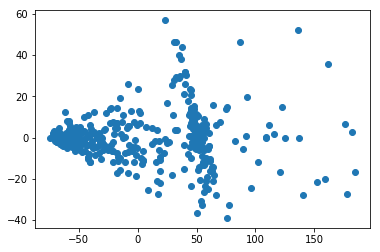

array([[127.,  24.,  38.],
       [102.,  49.,  38.],
       [135.,  98.,  26.],
       ...,
       [ 17.,   3.,   1.],
       [  8.,   5.,   1.],
       [  5.,   0.,   2.]])

In [22]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

#A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
A_rep = np.zeros((conf_mat.shape[0], Kl))
for t in range(A_rep.shape[0]):
    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [23]:
#different M_seted??
M_seted = 3

In [31]:
gMixture_Ind1 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind1.define_model("default rnn text", embed=embedding_matrix)

#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
gMixture_Ind1.define_model_group("perceptron", T, embed=True, embed_M=A, BatchN=True,bias=False)

logL_hists,i_r = gMixture_Ind1.multiples_run(1,X_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002479 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (14600, 3)
Betas:  (3, 3, 3)
Q estimate:  (43786, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 31.49 sec)	logL: -24985.357	
Iter 2/50
M step: done,  E step: done //  (in 27.70 sec)	logL: -23007.584	Tol1: 0.07916	Tol2: 0.26617	
Iter 3/50
M step: done,  E step: done //  (in 27.50 sec)	logL: -21947.745	Tol1: 0.04606	Tol2: 0.16960	
Iter 4/50
M step: done,  E step: done //  (in 28.37 sec)	logL: -21259.809	Tol1: 0.03134	Tol2: 0.15773	
Iter 5/50
M step: done,  E step: done //  (in 26.93 sec)	logL: -20761.514	Tol1: 0.02344	Tol2: 0.18205	
Iter 6/50
M step: done,  E step: done //  (in 27.94 sec)	logL: -19810.373	Tol1: 0.04581	Tol2: 0.15533	
Iter 7/50
M step: done,  E step: done //  (in 27.66 sec)	logL: -19578.498	Tol1: 0.01170	Tol2: 0.12172	
Iter 8/50
M step: done,  E step: done

In [25]:
Z_train_p = gMixture_Ind1.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind1.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind1.get_predictions_g(T_idx_unique) 

In [ ]:
gMixture_Ind3 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("default rnn text", embed=embedding_matrix)

gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN

logL_hists,i_r = gMixture_Ind3.multiples_run(10,X_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL) 

In [ ]:
Z_train_p = gMixture_Ind3.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [29]:
#Import it:
from code.evaluation import Evaluation_metrics

In [ ]:
evaluate = Evaluation_metrics(model_UB,'keras',X_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [30]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
#prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
prob_Yx = np.tensordot(Z_train_p, mv_conf_probas,axes=[[1],[0]])
prob_Yxt = np.tile(prob_Yx, (T,1,1)).transpose([1,0,2])

#results1 = evaluate.calculate_metrics(conf_pred=prob_Yzt,yo_pred=prob_Yxt, conf_pred_G = mv_conf_probas)

#immitate annotators
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***
Train
A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.8577,0.4632,0.8238,0.5143


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.5488,0.5488,0.5404


In [45]:
evaluate = Evaluation_metrics(model_mvhard,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yx = np.tensordot(Z_train_p, mv_conf_probas,axes=[[1],[0]])
prob_Yxt = np.tile(prob_Yx, (T,1,1)).transpose([1,0,2])

#results1 = evaluate.calculate_metrics(conf_pred=prob_Yzt,yo_pred=prob_Yxt, conf_pred_G = mv_conf_probas)

#immitate annotators
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.7799,0.5652,0.7704,0.5839


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.925,0.925,0.8638


In [47]:
evaluate = Evaluation_metrics(model_ds,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
#results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
#                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))
prob_Yxt = np.tensordot(Z_train_p, ds_conf,axes=[[1],[1]])
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)


print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


/home/fmena/Desktop/Dataset_Tesis/MixtureofGroups/code/evaluation.py:192: RuntimeWarning: divide by zero encountered in log
  cross_entropy_loss = -np.mean(np.sum(keras.utils.to_categorical(t_annotations,num_classes=prob_data.shape[-1])*np.log(prob_data),axis=-1))
/home/fmena/Desktop/Dataset_Tesis/MixtureofGroups/code/evaluation.py:192: RuntimeWarning: invalid value encountered in multiply
  cross_entropy_loss = -np.mean(np.sum(keras.utils.to_categorical(t_annotations,num_classes=prob_data.shape[-1])*np.log(prob_data),axis=-1))


A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.808,NaN,0.7967,NaN


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.95,0.95,0.9059


In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(X_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs (Uniform priors) ***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individual-T multiples runs***
Train
A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.8865,0.2867,0.8856,0.2922


Test


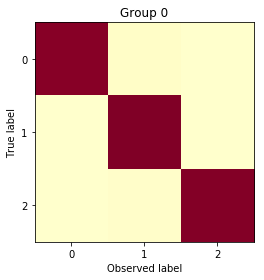

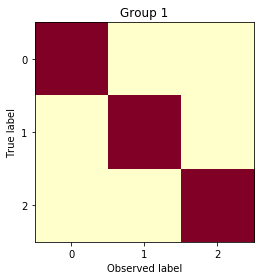

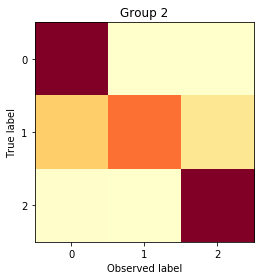

Inertia JS: 0.06117321321558042
Inertia NormF: 0.12512152805983434
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.2950,116,0.0505,0.9911,0.9956,0.9867,0.0101,1,0.0612,0.1251,0.975,0.975
1,1,0.3634,143,0.0086,0.9989,0.9995,0.9984,0.0005,0,0.0612,0.1251,0.975,0.975
2,2,0.3415,134,0.3399,0.8497,0.9093,0.7745,0.0424,0,0.0612,0.1251,1.000,1.000


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.975,0.975,0.9471


In [32]:
evaluate = Evaluation_metrics(gMixture_Ind1,'our1') 
aux = gMixture_Ind1.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind1.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual-T multiples runs***")

print("Train")
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind1.get_confusionM()
y_o_groups = gMixture_Ind1.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual-K multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

### project confusion matrices

In [42]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_I2 = flatten_conf(gMixture_Ind2.get_confusionM())
centroids_plot_I3 = flatten_conf(gMixture_Ind3.get_confusionM())

from sklearn.decomposition import PCA
model = PCA(2)

to_plot = model.fit_transform(to_plot)
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_I2 = model.transform(centroids_plot_I2)
centroids_plot_I3 = model.transform(centroids_plot_I3)

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Centroids Global")
plt.scatter(centroids_plot_I2[:,0], centroids_plot_I2[:,1],s=150, marker="X", color='magenta',label="Centroids Individual 2")
plt.scatter(centroids_plot_I3[:,0], centroids_plot_I3[:,1], s=150, marker="X", color='hotpink',label="Centroids Individual 3")

plt.legend()
plt.show()

In [ ]:
##plotear probabilidades de matriz  de conf..